#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1RPJmJdz1J3in5LNf2xOb_Uu47uepMDgp',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '19uWgoaz0WwBr1g7stjV71z7LeO7Idedh',
    'test': '1hXT0X_Z6F4rDnMmezl46yKgEm1IZ2eLd',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=19uWgoaz0WwBr1g7stjV71z7LeO7Idedh
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:02<00:00, 42.3MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 1.
Label code corresponds to BACK class.


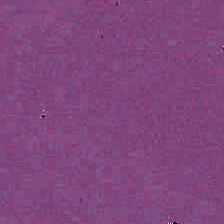

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [7]:

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as T
from PIL import Image

class HistologyTorchDataset(TorchDataset):
    """
    Обёртка над Dataset для использования с PyTorch.

    base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
    transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

    """
    def __init__(self, base_dataset, transform=None):
        self.base = base_dataset
        # Минимальный transform по умолчанию:
        # np.uint8 [0, 255] -> float32 [0.0, 1.0]
        self.transform = transform or T.Compose([T.ToPILImage(), T.ToTensor()])

    def __len__(self):
        # Размер датасета
        return len(self.base.images)

    def __getitem__(self, idx):
        """
        Возвращает (image_tensor, label) для PyTorch.
        image_tensor: torch.Tensor формы [3, H, W]
        label: int
        """
        img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
        img = self.transform(img)
        return img, label

### Пример использвания класса HistologyTorchDataset

In [8]:
print("Пример использования PyTorch-обёртки над Dataset")

base_train = Dataset('train_tiny')

# Создаём PyTorch-совместимый датасет
train_ds = HistologyTorchDataset(base_train)

# DataLoader автоматически создаёт батчи и перемешивает данные
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

# Берём один батч и выводим информацию
images_batch, labels_batch = next(iter(train_loader))

print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
print("Пример меток:", labels_batch[:10].tolist())

print("Тип images_batch:", type(images_batch))
print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=19uWgoaz0WwBr1g7stjV71z7LeO7Idedh
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:02<00:00, 35.6MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [1, 7, 8, 4, 4, 5, 1, 0]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class Metrics:
    @staticmethod
    def plot_confusion_matrix(gt, pred):
      cm = confusion_matrix(gt, pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TISSUE_CLASSES)
      disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
      plt.title("Confusion Matrix")
      plt.show()

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))
        Metrics.plot_confusion_matrix(gt, pred)

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import torchvision
import torchvision.transforms as T

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [11]:
def dataset_to_loader(dataset: Dataset, batch_size: int, shuffle: bool=True, transform=None):
  ds = HistologyTorchDataset(dataset, transform)
  loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
  return loader

In [12]:
train_transform = T.Compose([
  T.ToPILImage(),

  # Геометрические трансформации должны хорошо помогать, клетки могут быть по-разному ориентированы геометрически
  T.RandomHorizontalFlip(p=0.5),
  T.RandomVerticalFlip(p=0.5),
  T.RandomRotation(degrees=15),
  T.ToTensor(),
])

In [13]:
class Model:
    def __init__(self):
      weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
      self.model = convnext_tiny(weights=weights)
      self.model.classifier[2] = nn.Linear(768, len(TISSUE_CLASSES))


      self.train_state = 0

    def save(self, name: str):
        print("Saving model")
        model_data = {}
        for key, param in self.model.state_dict().items():
            model_data[key] = param.cpu().numpy()

        model_data['train_state'] = self.train_state
        np.savez(f'/content/drive/MyDrive/{name}.npz', **model_data)

    def load(self, name: str):
        name_to_id_dict = {
            'best': '1wvTrM-b332ucwbONmotDjo0lvk-KKN8a'
        }
        output = f'{name}.npz'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        np_obj = np.load(f'{name}.npz')
        state_dict = self.model.state_dict()
        for name in state_dict.keys():
          state_dict[name] = torch.from_numpy(np_obj[name])

        self.model.load_state_dict(state_dict)
        self.model.to(DEVICE)
        self.train_state = np_obj['train_state']

    def train(self, dataset: Dataset):
        # you can add some plots for better visualization,
        train_loader = dataset_to_loader(dataset, 16, transform=train_transform)
        print(f'Training started')

        if self.train_state == 0:
          print("Training classifier")
          for param in self.model.classifier.parameters():
            param.requires_grad = True
          for param in self.model.features.parameters():
            param.requires_grad = False

          model = self.model.to(DEVICE)

          criterion = nn.CrossEntropyLoss()
          optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

          for epoch in tqdm(range(5)):
            model.train()
            running_loss = 0.0

            for xb, yb in train_loader:
              xb = xb.to(DEVICE)
              yb = yb.to(DEVICE, dtype=torch.long)

              optimizer.zero_grad()
              logits = model(xb)
              loss = criterion(logits, yb)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            print(f"[Epoch {epoch+1}/5] Train loss: {avg_loss:.4f}")
          self.train_state = 1
          self.save('classifier_stage')

        if self.train_state == 1:
          print("Training feature extractor")

          for param in self.model.classifier.parameters():
            param.requires_grad = False
          for param in self.model.features.parameters():
            param.requires_grad = True

          model = self.model.to(DEVICE)

          optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


          for epoch in tqdm(range(1)):
            running_loss = 0
            model.train()

            for xb, yb in train_loader:
              xb = xb.to(DEVICE)
              yb = yb.to(DEVICE, dtype=torch.long)
              optimizer.zero_grad()
              logits = model(xb)
              loss = criterion(logits, yb)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

            print(f"[Epoch {epoch+1}/1] feature extractor train loss: {running_loss/len(train_loader):.4f}")

          self.train_state = 2
          self.save('features_stage')

        if self.train_state == 2:
          print("Training whole model")
          for param in self.model.classifier.parameters():
            param.requires_grad = True
          for param in self.model.features.parameters():
            param.requires_grad = True

          model = self.model.to(DEVICE)

          criterion = nn.CrossEntropyLoss()
          optimizer = torch.optim.Adam(model.parameters(), lr=1e-5 * 2)
          for epoch in tqdm(range(5)):
            model.train()
            running_loss = 0.0

            for xb, yb in train_loader:
              xb = xb.to(DEVICE)
              yb = yb.to(DEVICE, dtype=torch.long)

              optimizer.zero_grad()
              logits = model(xb)
              loss = criterion(logits, yb)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            print(f"[Epoch {epoch+1}/5] loss: {avg_loss:.4f}")

          self.save('final')

        print(f'training done')

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        test_loader = dataset_to_loader(dataset, 32, shuffle=False)
        self.model.eval()
        predictions = []
        gts = []
        with torch.no_grad():
            for xt, yt in test_loader:
              xt = xt.to(DEVICE)
              yt = yt.to(DEVICE, dtype=torch.long)
              logits_t = self.model(xt)
              y_pred = logits_t.argmax(dim=1).cpu()
              predictions.extend(y_pred.tolist())
              gts.extend(yt.tolist())

        Metrics.print_all(gts, predictions, "_")
        return predictions

    def test_on_image(self, img: np.ndarray):
        x = torch.from_numpy(img).to(DEVICE)
        self.model.eval()
        return self.model(x)


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [14]:
d_train = Dataset('train')
d_test = Dataset('test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RPJmJdz1J3in5LNf2xOb_Uu47uepMDgp
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:32<00:00, 63.7MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1hXT0X_Z6F4rDnMmezl46yKgEm1IZ2eLd
To: /content/test.npz
100%|██████████| 525M/525M [00:09<00:00, 58.0MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [15]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    model.load('best')

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 132MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1wvTrM-b332ucwbONmotDjo0lvk-KKN8a
From (redirected): https://drive.google.com/uc?id=1wvTrM-b332ucwbONmotDjo0lvk-KKN8a&confirm=t&uuid=1da6f21b-48a0-4ede-b578-a70736df0017
To: /content/best.npz
100%|██████████| 111M/111M [00:01<00:00, 76.0MB/s]


Пример тестирования модели на части набора данных:

metrics for _:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:


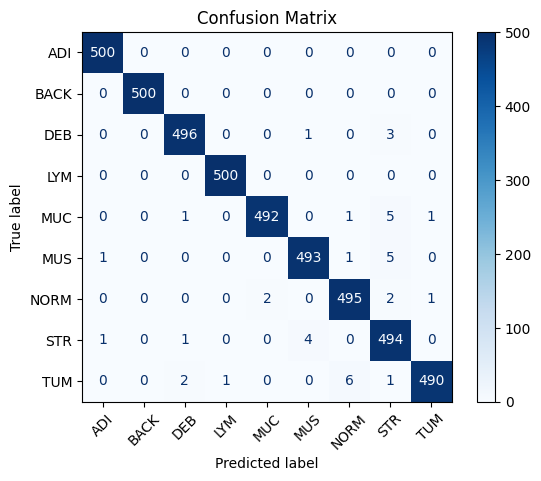

metrics for 10% of test:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:


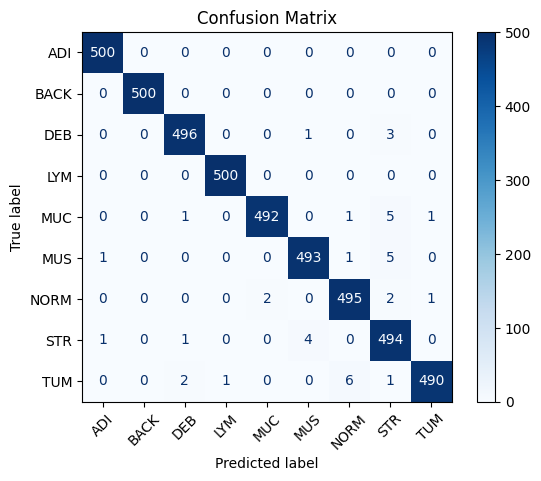

In [16]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Пример тестирования модели на полном наборе данных:

metrics for _:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:


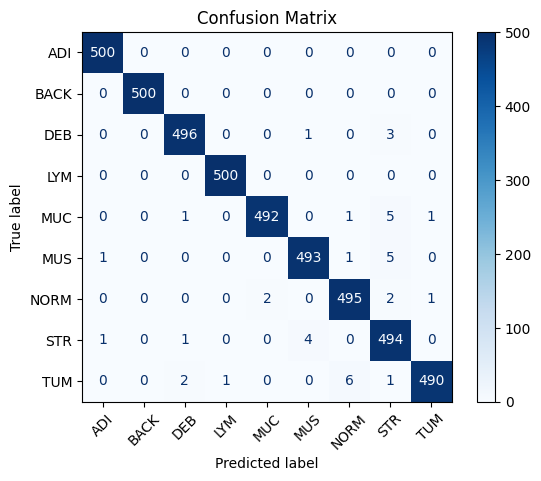

metrics for test:
	 accuracy 0.9911:
	 balanced accuracy 0.9911:


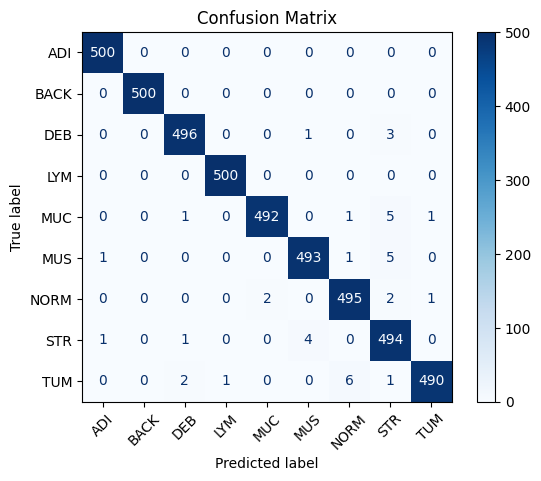

In [17]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### PyTorch

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

Downloading...
From (original): https://drive.google.com/uc?id=1wvTrM-b332ucwbONmotDjo0lvk-KKN8a
From (redirected): https://drive.google.com/uc?id=1wvTrM-b332ucwbONmotDjo0lvk-KKN8a&confirm=t&uuid=9923ac74-3326-486d-9894-c7bda2889e4b
To: /content/best.npz
100%|██████████| 111M/111M [00:01<00:00, 80.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 50.6MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
metrics for _:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


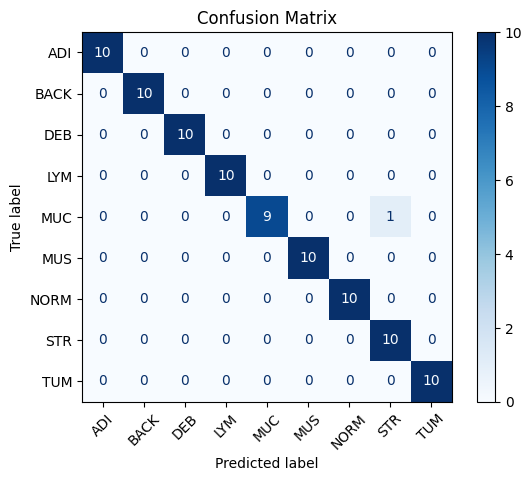

metrics for test-tiny:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


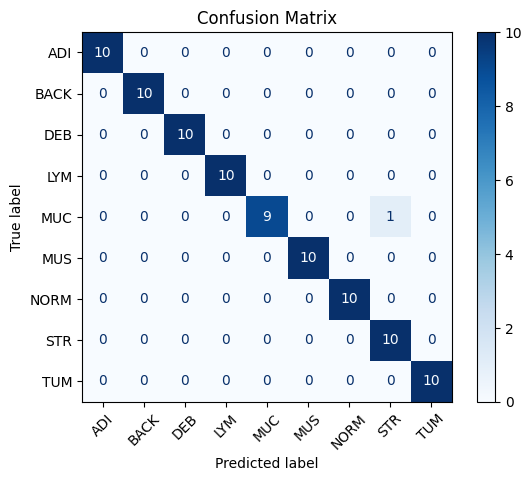

In [18]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Отмонтировать Google Drive.

In [19]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [20]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

Function f is caluclated 128 times in 0.031754102000036255s.


### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




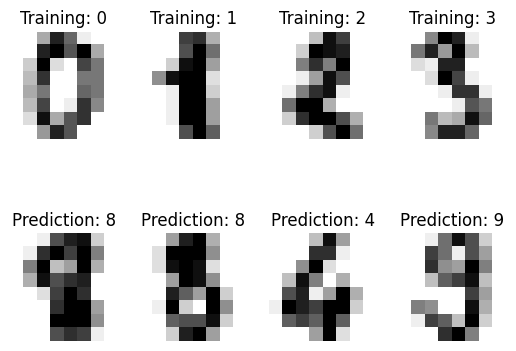

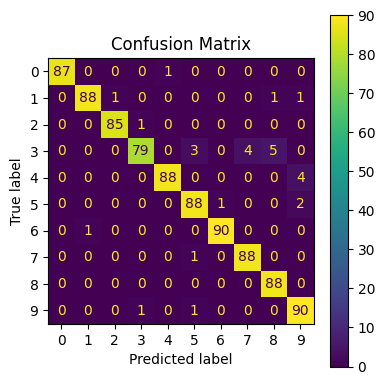

In [21]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

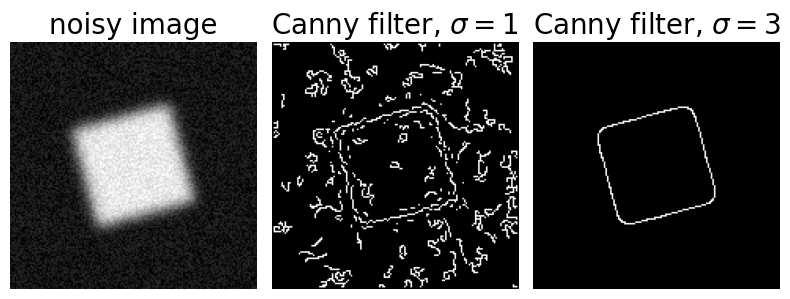

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [23]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dev/prak_nn_1/tmp'

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"